# Qubit dispersive readout with Qiskit Pulse

In our superconducting quantum processor, the state of the qubit is entangled with an observable of the resonator which allows us to read the state of the qubit by probing the resonator. The qubit-resonator interaction is described by the [Jaynes-Cummings Hamiltonian](https://qiskit.org/textbook/ch-quantum-hardware/Jaynes-Cummings-model.html). In the dispersive limit, the qubit-resonator frequency detuning $\Delta$ is large compared to their coupling rate $g$ and the resonator linewidth $\kappa$: $g, \kappa \ll | \Delta |$. Assuming that we only have a few photons present in the resonator, the Hamiltonian of the qubit-resonator system takes the form:

$H_{JC(disp)}=(\omega_r+ \chi \sigma_z) a^\dagger a + \frac{1}{2} \tilde{\omega}_q \sigma_z$

where $\chi \approx -g^2/\Delta$ is the dispersive shift (the negative sign is due to the fact that the transmon has a negative anharmonicity), and $\tilde{\omega}_q= \omega_q+g^2/\Delta$ is the modified qubit frequency, experiencing a Lamb shift. The dispersive shift allows us to distinguish the state of the qubit by probing the resonator frequency, and enables us to perform $\textit{quantum non-demolition}$ (QND) readout of the qubit.

In this chapter we investigate dispersive readout with Qiskit Pulse, and use it distinguish the qubit state between $|0 \rangle$ and $|1 \rangle$ using single-shot measurements. 


## 0.Getting started  
We'll first get our basic dependencies and helper functions set up and ready to go.

In [1]:
%matplotlib inline
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.test.mock import FakeArmonk

# Loading your IBM Q account(s)
provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')
#IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')
#backend = FakeArmonk()

We then extract the default backend configuration and settings for the selected chip

In [27]:
backend_config = backend.configuration()
backend_defaults = backend.defaults()
backend.configuration().parametric_pulses = []

inst_sched_map = backend_defaults.instruction_schedule_map

style = SchedStyle(figsize=(3, 2), title_font_size=10, axis_font_size=8)

/opt/conda/lib/python3.8/site-packages/qiskit/visualization/pulse/qcstyle.py:126: DeprecationWarning: The legacy pulse drawer is deprecated along with this stylesheet. Please use new drawer `qiskit.visualization.pulse_drawer_v2` with new stylesheet classes provided by `qiskit.visualization.pulse_v2`. You can choose one of `IQXStandard`, `IQXSimple`, `IQXDebugging`.
  warnings.warn('The legacy pulse drawer is deprecated along with this stylesheet. '


Next we define some helper functions that we will use for fitting and interpreting our data

In [26]:
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter

# samples need to be multiples of 16 to accommodate the hardware limitations
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

# process the reflective measurement results
# in a reflective measurement the data is encoded in the phase of the output signal
def process_reflective_measurement(freqs,values):
    phase_grad = np.gradient(savgol_filter(np.unwrap(np.angle(values)),5,3),freqs)
    #phase_grad = np.gradient(np.unwrap(np.angle(values)),freqs)
    return (phase_grad-min(phase_grad))/(max(phase_grad)-min(phase_grad)) - 1

# lorentzian function
def lorentzian(f, f0, k, a, offs):
    return -a*k/(2*np.pi)/((k/2)**2+(f-f0)**2)+offs

#fit_lorentzian takes two arrays that contain the frequencies and experimental output values of each frequency respectively. 
#returns the lorentzian parameters that best fits this output of the experiment.
#popt are the fit parameters and pcov is the covariance matrix for the fit
def fit_lorentzian(freqs,values):
    p0=[freqs[np.argmin(values)],(freqs[-1]-freqs[0])/2,min(values),0]
    bounds=([freqs[0],0,-np.inf,-np.inf],[freqs[-1],freqs[-1]-freqs[0],np.inf,np.inf])
    popt,pcov=curve_fit(lorentzian, freqs, values, p0=p0, bounds=bounds)
    return popt,pcov

## 1. Measuring the dispersive shift $\chi$

We measure the dispersive shift $\chi$ of the resonator by measuring the resonator frequency while the qubit is in the $|0 \rangle$ state, and comparing it to the scenario where the qubit is in the $|1 \rangle$ state. 

In [31]:
from qiskit import pulse            # This is where we access all of our Pulse features!
from qiskit.pulse import Play, Acquire
import qiskit.pulse.library as pulse_lib
import numpy as np

dt=backend_config.dt   # hardware resolution

qubit=0   # qubit used in our experiment

drive_chan = pulse.DriveChannel(qubit)  # microwave drive channel
meas_chan = pulse.MeasureChannel(qubit) # resonator channel
acq_chan = pulse.AcquireChannel(qubit)  # readout signal acquisition channel

measure = inst_sched_map.get('measure', qubits=[qubit]) # We start using the default backend measurement configurations
measure

Schedule((0, Acquire(22400, AcquireChannel(0), MemorySlot(0))), (0, Play(GaussianSquare(duration=22400, amp=(-0.3584733362723958+0.05040701520361846j), sigma=64, width=22144, name='gaussian_square_b937'), MeasureChannel(0), name='gaussian_square_b937')), name="measure")

Here we define the pulse sequence for measuring the resonator frequency while the qubit is in the $|0 \rangle$ state. In our system the qubit is initalized to $|0 \rangle$, so we would only have to perform a resonator frequency sweep.

/opt/conda/lib/python3.8/site-packages/qiskit/pulse/schedule.py:1549: UserWarning: Legacy stylesheet is specified. This is ignored in the new drawer. Please check the API documentation for this method.
  warnings.warn('Legacy stylesheet is specified. This is ignored in the new drawer. '


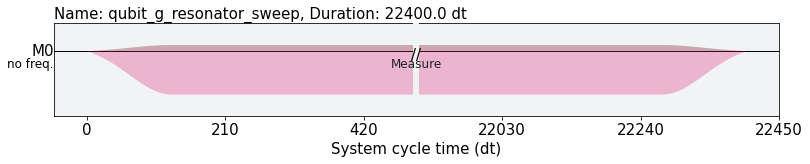

In [32]:
with pulse.build(name='qubit_g_resonator_sweep',backend=backend) as pulse_qubit_g:
    pulse.call(measure) 

pulse_qubit_g.draw(style=style)

Here we define the pulse sequence for measuring the resonator frequency while the qubit is in the $|1\rangle$ state. To do this, we first excite the qubit to the $|1 \rangle$ state by applying a $\pi$-pulse, followed by measuring the resonator.

/opt/conda/lib/python3.8/site-packages/qiskit/pulse/schedule.py:1549: UserWarning: Legacy stylesheet is specified. This is ignored in the new drawer. Please check the API documentation for this method.
  warnings.warn('Legacy stylesheet is specified. This is ignored in the new drawer. '


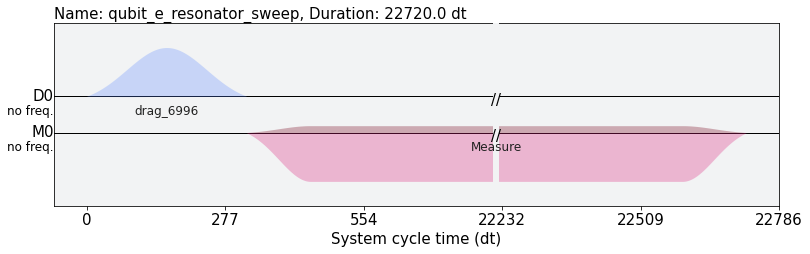

In [33]:
with pulse.build(name='qubit_e_resonator_sweep',backend=backend) as pulse_qubit_e:
    #drive the resonator with low power
    with pulse.align_sequential():
        pulse.x(qubit)
        pulse.call(measure) 
    
pulse_qubit_e.draw(style=style)

Here we set the frequency sweep points to find the resonator frequency

In [34]:
center_freq = backend_defaults.meas_freq_est[qubit]  # an estimate for the resonator frequency
qubit_freq = backend_defaults.qubit_freq_est[qubit]
freq_span = 1e6 # resonator scan span. The span should be larger than the resonator linewidth kappa

frequencies_range = np.linspace(center_freq-freq_span/2,center_freq+freq_span/2,31) + 2.2e6
# list of resonator frequencies for the experiment
schedule_frequencies = [{meas_chan: freq , drive_chan: qubit_freq} for freq in frequencies_range] 

And finally, we send our pulse sequence to the hardware

In [35]:
from qiskit import assemble
from qiskit.tools.monitor import job_monitor

num_shots_per_frequency =  2*1024 
resonator_sweep_pulse_qubit_g = assemble(pulse_qubit_g,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)

resonator_sweep_pulse_qubit_e = assemble(pulse_qubit_e,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)

job_qubit_g = backend.run(resonator_sweep_pulse_qubit_g)
job_monitor(job_qubit_g)

job_qubit_e = backend.run(resonator_sweep_pulse_qubit_e)
job_monitor(job_qubit_e)

resonator_qubit_g_results = job_qubit_g.result(timeout=120)
resonator_qubit_e_results = job_qubit_e.result(timeout=120)

<ipython-input-35-30288de5c05f>:19: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job_qubit_g = backend.run(resonator_sweep_pulse_qubit_g)


Job Status: job has successfully run


<ipython-input-35-30288de5c05f>:22: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job_qubit_e = backend.run(resonator_sweep_pulse_qubit_e)


Job Status: job has successfully run


And then we access the measurement data. The resonator in the backend we use for this tutorial is measured reflectively, so the spectroscopy data is encoded in the phase of the output signal. We fit a Lorentzian function to the data to extract the resonator frequencies for qubit in $|0\rangle$ and $|1\rangle$ state to find the resonator dispersive shift $\chi$.

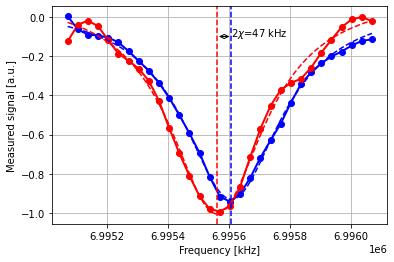

$2\chi=47.640460$ kHz


In [36]:
import matplotlib.pyplot as plt

resonator_qubit_g_values = []
for i in range(len(resonator_qubit_g_results.results)):
    qubit_g = resonator_qubit_g_results.get_memory(i)
    resonator_qubit_g_values.append(qubit_g[qubit])
    
resonator_qubit_e_values = []
for i in range(len(resonator_qubit_e_results.results)):
    qubit_e = resonator_qubit_e_results.get_memory(i)
    resonator_qubit_e_values.append(qubit_e[qubit])

resonator_qubit_g_values = savgol_filter(process_reflective_measurement(frequencies_range, resonator_qubit_g_values),7,3)

resonator_qubit_e_values = savgol_filter(process_reflective_measurement(frequencies_range, resonator_qubit_e_values),7,3)

plt.plot(frequencies_range/1e3, resonator_qubit_g_values,'-o', color='blue', lw=2)

plt.plot(frequencies_range/1e3, resonator_qubit_e_values,'-o', color='red', lw=2)

popt_qubit_g,_=fit_lorentzian(frequencies_range,resonator_qubit_g_values)
f0_g, kappa_g, a, offset = popt_qubit_g

popt_qubit_e,_=fit_lorentzian(frequencies_range,resonator_qubit_e_values)
f0_e, kappa_e, a, offset = popt_qubit_e

fs=np.linspace(frequencies_range[0],frequencies_range[-1],1000)
plt.plot(fs/1e3, lorentzian(fs,*popt_qubit_g), color='blue', ls='--')
plt.plot(fs/1e3, lorentzian(fs,*popt_qubit_e), color='red', ls='--')

plt.axvline(x=f0_g/1e3, color='blue', ls='--')
plt.axvline(x=f0_e/1e3, color='red', ls='--')

plt.annotate("", xy=(f0_g/1e3, -.1), xytext=(f0_e/1e3, -.1), arrowprops=dict(arrowstyle="<->", color='black'))
plt.annotate("$2\chi$={:d} kHz".format(int((f0_g-f0_e)/1e3)), xy=(f0_g/1e3, -.1), color='black')
plt.grid()
plt.xlabel("Frequency [kHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

print(r'$2\chi={:1f}$ kHz'.format((f0_g-f0_e)/1e3))

## 2. Single-shot readout

The state of the qubit can be classified by considering the projection of the resonator response in two orthogonal quadratures $I$ and $Q$. We can use the resonator response for each *shot* of the experiment when the qubit is in the $|0 \rangle$ state versus the $| 1 \rangle$ state to draw a line which allows us discriminate between these two states in our future experiments. The quality of the single-shot readout can be quantified using the *assignment fidelity*, which is determined by the precentage of shots where the prepared state prior to readout matches the readout result, i.e. if we prepare $|0 \rangle$ we measure $0$ and if we prepare $|1\rangle$ we measure $1$.

In [1]:
fr=backend_defaults.meas_freq_est[qubit]
readout_frequencies = [{meas_chan: fr, drive_chan: qubit_freq}] 

shots = 8*1024 

single_shot_g_e_experiment = assemble([pulse_qubit_g, pulse_qubit_e],
                                backend=backend, 
                                meas_level=1,
                                meas_return='single',    #returns each single-shot trace instead of an average over all shots
                                shots=shots,
                                schedule_los=readout_frequencies)


job_single_shot_qubit_g_e = backend.run(single_shot_g_e_experiment)
job_monitor(job_single_shot_qubit_g_e)
single_shot_g_e_result = job_single_shot_qubit_g_e.result(timeout=120)

Traceback (most recent call last):
  File "<ipython-input-1-7cdaf3f41de8>", line 1, in <module>
    fr=backend_defaults.meas_freq_est[qubit]
NameError: name 'backend_defaults' is not defined

Use %tb to get the full traceback.


Here we descriminate between the single-shot traces of the $|0 \rangle$ and $|1 \rangle$ state using a [support vector machine (SVM)](https://monkeylearn.com/blog/introduction-to-support-vector-machines-svm/#:~:text=A%20support%20vector%20machine%20(SVM,able%20to%20categorize%20new%20text.), which is a supervised machine learning model. We use our knowledge of the prepared state prior to each measurement, combined with the resonator $I$ and $Q$ response to draw a line that allows us to descriminate between $|0 \rangle$ and $|1 \rangle$.

Text(0, 0.5, 'I [a.u.]')

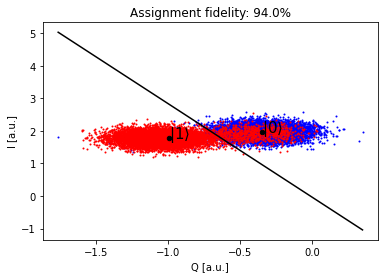

In [84]:
from sklearn import svm

scaling_factor=1e-15
g_values = single_shot_g_e_result.get_memory(0)[:,0]*1e-15
e_values = single_shot_g_e_result.get_memory(1)[:,0]*1e-15

g_traces=np.array([(np.real(val),np.imag(val)) for val in g_values])
g_classification=np.array([0 for _ in range(len(g_values))])
e_traces=np.array([(np.real(val),np.imag(val)) for val in e_values])
e_classification=np.array([1 for _ in range(len(g_values))])

svc = svm.SVC(kernel='linear').fit(np.concatenate((g_traces,e_traces)), np.concatenate((g_classification,e_classification)) )
w = svc.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(np.min([e_traces[:,0],g_traces[:,0]]), np.max([e_traces[:,0],g_traces[:,0]]))
yy = a * xx - (svc.intercept_[0]) / w[1]
score=svc.score(np.concatenate((g_traces,e_traces)), np.concatenate((g_classification,e_classification)))

plt.scatter(np.real(g_values), np.imag(g_values), color='b', s=1)
plt.scatter(np.real(e_values), np.imag(e_values), color='r', s=1)
plt.scatter(np.mean(g_traces[:,0]), np.mean(g_traces[:,1]),color='black', s=20)
plt.annotate(r'$|0 \rangle$', xy=(np.mean(g_traces[:,0]), np.mean(g_traces[:,1])), color='black', fontsize=15)
plt.scatter(np.mean(e_traces[:,0]), np.mean(e_traces[:,1]),color='black', s=20)
plt.annotate(r'$|1 \rangle$', xy=(np.mean(e_traces[:,0]), np.mean(e_traces[:,1])), color='black', fontsize=15)

plt.title('Assignment fidelity: {:.1f}%'.format(score*100))
plt.plot(xx, yy, 'k-')
plt.xlabel('Q [a.u.]')
plt.ylabel('I [a.u.]')

We can further breakdown the analysis of our readout assignment fidelity by considering the probability of measuring 0 if the qubit is prepared in the $|0\rangle$ state ($f_{gg}$) and probability of measuring 1 if the qubit is prepared in the $|1\rangle$ state ($f_{ee}$).

In [85]:
f_gg=svc.score(g_traces, g_classification)
f_ee=svc.score(e_traces, e_classification)
print(r'$f_gg$: ',f_gg)
print(r'$f_ee$: ',f_ee)

$f_gg$:  0.97900390625
$f_ee$:  0.900146484375


As expected, we observe two clusters: one associated with $|0\rangle$ and another associated with $|1\rangle$. There are a few possible sources of error in state discrimination:
1. The cluster separability, where the clusters associated with $|0\rangle$ and $|1\rangle$ overlap
2. Qubit relaxation, where due to $T_1$ decay during the readout state $|1\rangle$ is classified as 0.

Now we define a function which generates the pulse sequence for the qubit initalized to $|0\rangle$ and $|1\rangle$ with different readout duration and readout amplitude.

In [46]:
def single_shot_readout_pulses(duration, amp=0.36):
    
    readout_sigma = 10e-9 
    readout_drive=pulse_lib.GaussianSquare(duration = get_closest_multiple_of_16(duration//dt),
                                 amp = amp,
                                 sigma = get_closest_multiple_of_16(readout_sigma//dt),
                                 width = get_closest_multiple_of_16((duration-8*readout_sigma)//dt),
                                 name = 'readout tone')
    
    with pulse.build(name='resonator_sweep') as sweep_resonator:
        pulse.play(readout_drive, meas_chan) 
        pulse.acquire(duration = get_closest_multiple_of_16(duration//dt),
                    qubit_or_channel = pulse.AcquireChannel(qubit),
                    register = pulse.MemorySlot(qubit))
        
    with pulse.build(name='qubit_g_resonator_sweep',backend=backend) as pulse_qubit_g:
        pulse.call(sweep_resonator) 
        
    with pulse.build(name='qubit_e_resonator_sweep',backend=backend) as pulse_qubit_e:
        with pulse.align_sequential():
            pulse.x(qubit)
            pulse.call(sweep_resonator) 
            
    return [pulse_qubit_g, pulse_qubit_e]

### 2.1 Readout assignement fidelity and readout duration

In this section we study the effects of different values of readout duration on assignment fidelity.

In [47]:
fr=backend_defaults.meas_freq_est[qubit]
schedule_frequencies = [{meas_chan: fr, drive_chan: qubit_freq}] 

shots = 8*1024 

readout_durations=np.linspace(1e-6,20e-6,20)

single_shot_g_e_experiments = [assemble(single_shot_readout_pulses(duration=time),
                                backend=backend, 
                                meas_level=1,
                                meas_return='single',
                                shots=shots,
                                schedule_los=schedule_frequencies) for time in readout_durations]

single_shot_g_e_readout_duration_sweep=[]
for experiment in single_shot_g_e_experiments:
    job = backend.run(experiment)
    job_monitor(job)
    single_shot_g_e_readout_duration_sweep.append(job.result(timeout=120))


<ipython-input-47-5c504bbaaa40>:17: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(experiment)


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


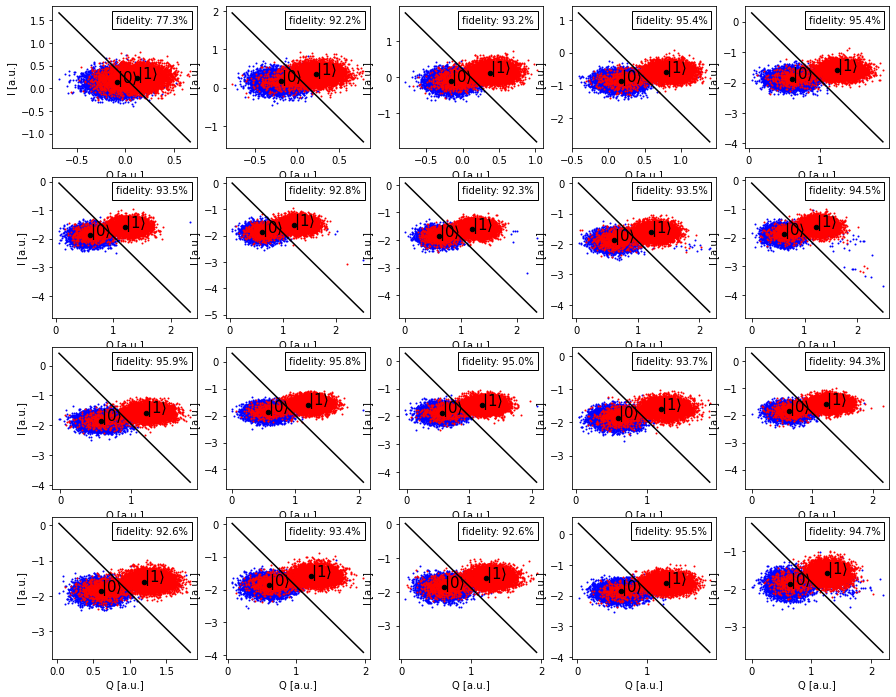

In [55]:
from sklearn import svm
from matplotlib.offsetbox import AnchoredText

scores=np.zeros(shape=readout_durations.shape)
scores_gg=np.zeros(shape=readout_durations.shape)
scores_ee=np.zeros(shape=readout_durations.shape)
fig, axs=plt.subplots(4,5,figsize=(15,12))
for i,time in enumerate(readout_durations):
    ax=axs[i//5,i%5]
    scaling_factor=1e-15
    g_values = single_shot_g_e_readout_duration_sweep[i].get_memory(0)[:,0]*1e-15
    e_values = single_shot_g_e_readout_duration_sweep[i].get_memory(1)[:,0]*1e-15

    g_traces=np.array([(np.real(val),np.imag(val)) for val in g_values])
    g_classification=np.array([0 for _ in range(len(g_values))])
    e_traces=np.array([(np.real(val),np.imag(val)) for val in e_values])
    e_classification=np.array([1 for _ in range(len(g_values))])

    svc = svm.SVC(kernel='linear').fit(np.concatenate((g_traces,e_traces)), np.concatenate((g_classification,e_classification)) )
    w = svc.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(np.min([e_traces[:,0],g_traces[:,0]]), np.max([e_traces[:,0],g_traces[:,0]]))
    yy = a * xx - (svc.intercept_[0]) / w[1]
    score=svc.score(np.concatenate((g_traces,e_traces)), np.concatenate((g_classification,e_classification)))
    scores[i]=score
    scores_gg[i]=svc.score(g_traces, g_classification)
    scores_ee[i]=svc.score(e_traces, e_classification)

    ax.add_artist(AnchoredText('fidelity: {:.1f}%'.format(score*100), loc=1))
    ax.scatter(np.real(g_values), np.imag(g_values), color='b', s=1)
    ax.scatter(np.real(e_values), np.imag(e_values), color='r', s=1)
    ax.scatter(np.mean(g_traces[:,0]), np.mean(g_traces[:,1]),color='black', s=20)
    ax.annotate(r'$|0 \rangle$', xy=(np.mean(g_traces[:,0]), np.mean(g_traces[:,1])), color='black', fontsize=15)
    ax.scatter(np.mean(e_traces[:,0]), np.mean(e_traces[:,1]),color='black', s=20)
    ax.annotate(r'$|1 \rangle$', xy=(np.mean(e_traces[:,0]), np.mean(e_traces[:,1])), color='black', fontsize=15)

    #ax.set_title('Assignment fidelity: {:.1f}%'.format(score*100))
    ax.plot(xx, yy, 'k-')
    ax.set_xlabel('Q [a.u.]')
    ax.set_ylabel('I [a.u.]')
        #plt.show()

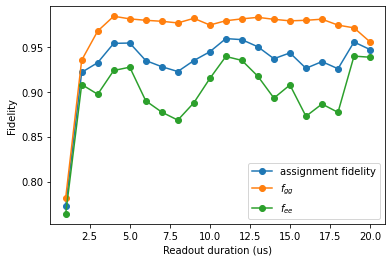

In [60]:
plt.plot(readout_durations*1e6, scores, '-o', label='assignment fidelity')
plt.plot(readout_durations*1e6, scores_gg, '-o',  label=r'$f_{gg}$')
plt.plot(readout_durations*1e6, scores_ee, '-o', label=r'$f_{ee}$')
plt.xlabel('Readout duration (us)')
plt.ylabel('Fidelity')
plt.legend()

Based on our experimental data we observe that up to 5$\mu$s as the readout duration increases, the seperation between the $0$ and $1$ clusters also increases, resulting in a higher readout assignment fidelity. However, for long readout durations qubit relaxation during readout leads to a degradation of the assignment fidelity.

### 2.2 Readout assignement fidelity and readout frequency

Next, we consider the effects of slightly changing the readout probe frequency on the single-shot clusters and assignment fidelity

In [66]:
fr=backend_defaults.meas_freq_est[qubit]
readout_freq_offset=np.linspace(-200e3,200e3,9)

shots = 8*1024 

readout_duration=4e-6

single_shot_g_e_experiments = [assemble(single_shot_readout_pulses(duration=readout_duration),
                                backend=backend, 
                                meas_level=1,
                                meas_return='single',
                                shots=shots,
                                schedule_los=[{meas_chan: fr+offset, drive_chan: qubit_freq}] ) for offset in readout_freq_offset]

single_shot_g_e_readout_freq_offset_sweep=[]
for experiment in single_shot_g_e_experiments:
    job = backend.run(experiment)
    job_monitor(job)
    single_shot_g_e_readout_freq_offset_sweep.append(job.result(timeout=120))

<ipython-input-66-a770adc9e210>:17: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(experiment)


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


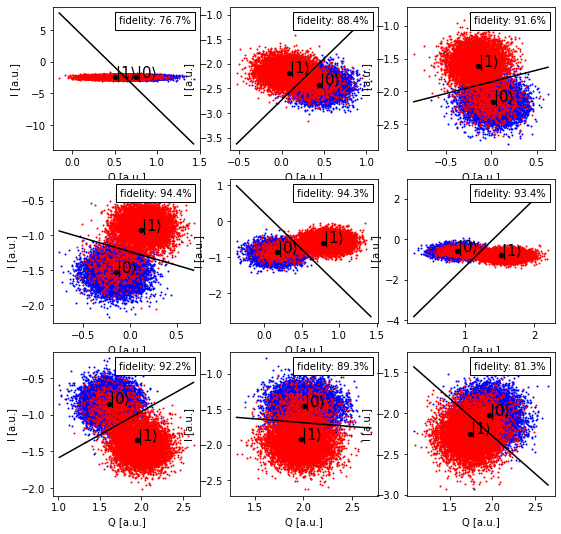

In [68]:
scores_freq=np.zeros(shape=readout_freq_offset.shape)
scores_gg_freq=np.zeros(shape=readout_freq_offset.shape)
scores_ee_freq=np.zeros(shape=readout_freq_offset.shape)
fig, axs=plt.subplots(3,3,figsize=(9,9))
for i,time in enumerate(readout_freq_offset):
    ax=axs[i//3,i%3]
    scaling_factor=1e-15
    g_values = single_shot_g_e_readout_freq_offset_sweep[i].get_memory(0)[:,0]*1e-15
    e_values = single_shot_g_e_readout_freq_offset_sweep[i].get_memory(1)[:,0]*1e-15

    g_traces=np.array([(np.real(val),np.imag(val)) for val in g_values])
    g_classification=np.array([0 for _ in range(len(g_values))])
    e_traces=np.array([(np.real(val),np.imag(val)) for val in e_values])
    e_classification=np.array([1 for _ in range(len(g_values))])

    svc = svm.SVC(kernel='linear').fit(np.concatenate((g_traces,e_traces)), np.concatenate((g_classification,e_classification)) )
    w = svc.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(np.min([e_traces[:,0],g_traces[:,0]]), np.max([e_traces[:,0],g_traces[:,0]]))
    yy = a * xx - (svc.intercept_[0]) / w[1]
    score=svc.score(np.concatenate((g_traces,e_traces)), np.concatenate((g_classification,e_classification)))
    scores_freq[i]=score
    scores_gg_freq[i]=svc.score(g_traces, g_classification)
    scores_ee_freq[i]=svc.score(e_traces, e_classification)

    ax.add_artist(AnchoredText('fidelity: {:.1f}%'.format(score*100), loc=1))
    ax.scatter(np.real(g_values), np.imag(g_values), color='b', s=1)
    ax.scatter(np.real(e_values), np.imag(e_values), color='r', s=1)
    ax.scatter(np.mean(g_traces[:,0]), np.mean(g_traces[:,1]),color='black', s=20)
    ax.annotate(r'$|0 \rangle$', xy=(np.mean(g_traces[:,0]), np.mean(g_traces[:,1])), color='black', fontsize=15)
    ax.scatter(np.mean(e_traces[:,0]), np.mean(e_traces[:,1]),color='black', s=20)
    ax.annotate(r'$|1 \rangle$', xy=(np.mean(e_traces[:,0]), np.mean(e_traces[:,1])), color='black', fontsize=15)

    #ax.set_title('Assignment fidelity: {:.1f}%'.format(score*100))
    ax.plot(xx, yy, 'k-')
    ax.set_xlabel('Q [a.u.]')
    ax.set_ylabel('I [a.u.]')
        #plt.show()

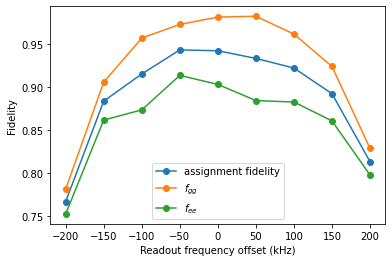

In [69]:
plt.plot(readout_freq_offset/1e3, scores_freq, '-o', label='assignment fidelity')
plt.plot(readout_freq_offset/1e3, scores_gg_freq, '-o',  label=r'$f_{gg}$')
plt.plot(readout_freq_offset/1e3, scores_ee_freq, '-o', label=r'$f_{ee}$')
plt.xlabel('Readout frequency offset (kHz)')
plt.ylabel('Fidelity')
plt.legend()

We observe that hanging the readout probe frequency affects the position of the single-shot clusters in the $I-Q$ plane. Slight changes in the readout probe frequency has strong effect on the readout assignment fidelity, and we by sweeping this parameter we can select an offset value that maximizes the fidelity.

### 2.3 Readout assignement fidelity and readout amplitude

Finally, we study the impact of the readout probe amplitude on the single-shot clusters and assignment fidelity.

In [76]:
fr=backend_defaults.meas_freq_est[qubit]


shots = 8*1024 

readout_duration=4e-6
freq_offset=-50e3
schedule_frequencies = [{meas_chan: fr+freq_offset, drive_chan: qubit_freq}] 
readout_amplitudes=np.linspace(.2,.8,13)

single_shot_g_e_experiments = [assemble(single_shot_readout_pulses(duration=readout_duration, amp=amp),
                                backend=backend, 
                                meas_level=1,
                                meas_return='single',
                                shots=shots,
                                schedule_los=schedule_frequencies) for amp in readout_amplitudes]

single_shot_g_e_readout_amplitude_sweep=[]
for experiment in single_shot_g_e_experiments:
    job = backend.run(experiment)
    job_monitor(job)
    single_shot_g_e_readout_amplitude_sweep.append(job.result(timeout=120))

<ipython-input-76-87758e3eeb7f>:20: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(experiment)


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


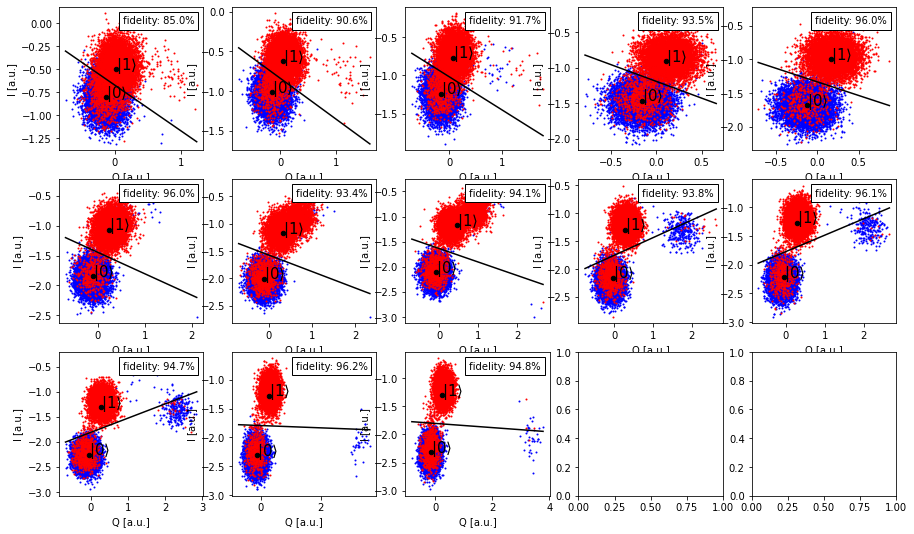

In [78]:
scores_amp=np.zeros(shape=readout_amplitudes.shape)
scores_gg_amp=np.zeros(shape=readout_amplitudes.shape)
scores_ee_amp=np.zeros(shape=readout_amplitudes.shape)
fig, axs=plt.subplots(3,5,figsize=(15,9))
for i,time in enumerate(readout_amplitudes):
    ax=axs[i//5,i%5]
    scaling_factor=1e-15
    g_values = single_shot_g_e_readout_amplitude_sweep[i].get_memory(0)[:,0]*1e-15
    e_values = single_shot_g_e_readout_amplitude_sweep[i].get_memory(1)[:,0]*1e-15

    g_traces=np.array([(np.real(val),np.imag(val)) for val in g_values])
    g_classification=np.array([0 for _ in range(len(g_values))])
    e_traces=np.array([(np.real(val),np.imag(val)) for val in e_values])
    e_classification=np.array([1 for _ in range(len(g_values))])

    svc = svm.SVC(kernel='linear').fit(np.concatenate((g_traces,e_traces)), np.concatenate((g_classification,e_classification)) )
    w = svc.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(np.min([e_traces[:,0],g_traces[:,0]]), np.max([e_traces[:,0],g_traces[:,0]]))
    yy = a * xx - (svc.intercept_[0]) / w[1]
    score=svc.score(np.concatenate((g_traces,e_traces)), np.concatenate((g_classification,e_classification)))
    scores_amp[i]=score
    scores_gg_amp[i]=svc.score(g_traces, g_classification)
    scores_ee_amp[i]=svc.score(e_traces, e_classification)

    ax.add_artist(AnchoredText('fidelity: {:.1f}%'.format(score*100), loc=1))
    ax.scatter(np.real(g_values), np.imag(g_values), color='b', s=1)
    ax.scatter(np.real(e_values), np.imag(e_values), color='r', s=1)
    ax.scatter(np.mean(g_traces[:,0]), np.mean(g_traces[:,1]),color='black', s=20)
    ax.annotate(r'$|0 \rangle$', xy=(np.mean(g_traces[:,0]), np.mean(g_traces[:,1])), color='black', fontsize=15)
    ax.scatter(np.mean(e_traces[:,0]), np.mean(e_traces[:,1]),color='black', s=20)
    ax.annotate(r'$|1 \rangle$', xy=(np.mean(e_traces[:,0]), np.mean(e_traces[:,1])), color='black', fontsize=15)

    #ax.set_title('Assignment fidelity: {:.1f}%'.format(score*100))
    ax.plot(xx, yy, 'k-')
    ax.set_xlabel('Q [a.u.]')
    ax.set_ylabel('I [a.u.]')
        #plt.show()

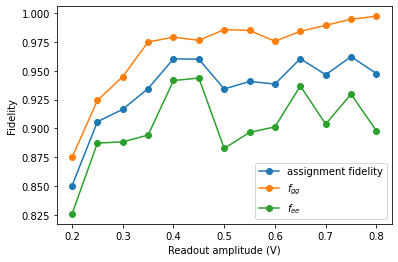

In [79]:
plt.plot(readout_amplitudes, scores_amp, '-o', label='assignment fidelity')
plt.plot(readout_amplitudes, scores_gg_amp, '-o',  label=r'$f_{gg}$')
plt.plot(readout_amplitudes, scores_ee_amp, '-o', label=r'$f_{ee}$')
plt.xlabel('Readout amplitude (V)')
plt.ylabel('Fidelity')
plt.legend()

As we increase the readout probe amplitude the single-shot clusters become more seperated as a result of improvd signal-to-noise ratio. However, at higher amplitude values we begin to populate the resonator with too many photons which violates the dispersive approximation (see the [Jaynes-Cummings Hamiltonian](https://qiskit.org/textbook/ch-quantum-hardware/Jaynes-Cummings-model.html) chapter). Hence, we need to appropriately limit the value of our readout amplitude.

### 2.4 Readout assignement fidelity with optimal parameters

To conclude this chapter, let us combine the optimal values for readout duration, frequency offset, and amplitude that we found from our earlier experiments and check the readout assignment fidelity. Here we use ~1.5 million shots for each pulse sequence.

In [80]:
fr=backend_defaults.meas_freq_est[qubit]


shots = 8*1024 

readout_duration=4e-6
freq_offset=-50e3
readout_amplitude=0.4

schedule_frequencies = [{meas_chan: fr+freq_offset, drive_chan: qubit_freq}] 

repeats=20
pulses=[]
for _ in range(repeats):
    pulses+=single_shot_readout_pulses(duration=readout_duration, amp=readout_amplitude)

single_shot_g_e_experiment = assemble(pulses,
                                backend=backend, 
                                meas_level=1,
                                meas_return='single',
                                shots=shots,
                                schedule_los=schedule_frequencies)

job_single_shot_qubit_g_e = backend.run(single_shot_g_e_experiment)
job_monitor(job_single_shot_qubit_g_e)
single_shot_qubit_g_e_result_repeated = job_single_shot_qubit_g_e.result(timeout=120)

<ipython-input-80-efac9d80e53d>:24: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job_single_shot_qubit_g_e = backend.run(single_shot_g_e_experiment)


Job Status: job has successfully run


Text(0, 0.5, 'I [a.u.]')

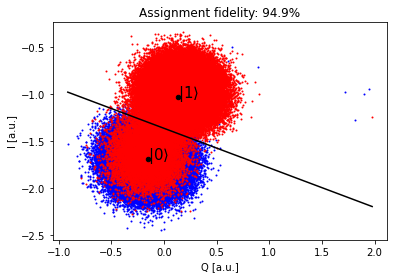

In [82]:
scaling_factor=1e-15
g_values = np.array([single_shot_qubit_g_e_result_repeated.get_memory(2*i)[:,0]*1e-15 for i in range(repeats)]).flatten()
e_values = np.array([single_shot_qubit_g_e_result_repeated.get_memory(2*i+1)[:,0]*1e-15 for i in range(repeats)]).flatten()

g_traces=np.array([(np.real(val),np.imag(val)) for val in g_values])
g_classification=np.array([0 for _ in range(len(g_values))])
e_traces=np.array([(np.real(val),np.imag(val)) for val in e_values])
e_classification=np.array([1 for _ in range(len(g_values))])

svc = svm.SVC(kernel='linear').fit(np.concatenate((g_traces,e_traces)), np.concatenate((g_classification,e_classification)) )
w = svc.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(np.min([e_traces[:,0],g_traces[:,0]]), np.max([e_traces[:,0],g_traces[:,0]]))
yy = a * xx - (svc.intercept_[0]) / w[1]
score=svc.score(np.concatenate((g_traces,e_traces)), np.concatenate((g_classification,e_classification)))

plt.scatter(np.real(g_values), np.imag(g_values), color='b', s=1)
plt.scatter(np.real(e_values), np.imag(e_values), color='r', s=1)
plt.scatter(np.mean(g_traces[:,0]), np.mean(g_traces[:,1]),color='black', s=20)
plt.annotate(r'$|0 \rangle$', xy=(np.mean(g_traces[:,0]), np.mean(g_traces[:,1])), color='black', fontsize=15)
plt.scatter(np.mean(e_traces[:,0]), np.mean(e_traces[:,1]),color='black', s=20)
plt.annotate(r'$|1 \rangle$', xy=(np.mean(e_traces[:,0]), np.mean(e_traces[:,1])), color='black', fontsize=15)

plt.title('Assignment fidelity: {:.1f}%'.format(score*100))
plt.plot(xx, yy, 'k-')
plt.xlabel('Q [a.u.]')
plt.ylabel('I [a.u.]')

In [83]:
f_gg=svc.score(g_traces, g_classification)
f_ee=svc.score(e_traces, e_classification)
print(r'f_gg',f_gg)
print(r'f_ee',f_ee)

f_gg 0.984637451171875
f_ee 0.91427001953125


We observe that using our optimized parameters we are able to increase the readout assignment fidelity compared to the default values that we started with!! 